# Algorytm symulowanego wyżarzania

Symulowane wyżarzanie (*simulated annealing*) to probabilistyczna technika optymalizacyjna inspirowana procesem wyżarzania w metalurgii. Naśladuje fizyczny proces podgrzewania i powolnego schładzania materiału w celu usunięcia defektów. W kontekście optymalizacji „temperatura” jest skalarnym parametrem algorytmu. 

## Ogólny zarys
Rozpoczyna się od dowolnie wybranego początkowego rozwiązania i wysokiej temperatury, która jest stopniowo obniżana. Na każdym kroku algorytm losowo modyfikuje bieżące rozwiązanie w celu wygenerowania nowego kandydata. Jeśli nowe rozwiązanie jest lepsze, zostaje zaakceptowane. Jeśli jest gorsze, może również zostać zaakceptowane z pewnym prawdopodobieństwem, które jest proporcjonalne do temperatury. Pozwala to algorytmowi uniknąć lokalnych ekstremów i z czasem przybliżyć rozwiązanie optymalne w skali globalnej.

Tutaj zostanie przedstawiona podstawowa wersja tego algorytmu. Składa się z dwóch pętli. Pierwsza z nich, zewnętrzna, zarządza zmianą temperatury. Druga, wewnętrzna, determinuje ile sąsiadów jest sprawdzanych dla danej temperatury. Poniżej jest zaprezentowany pseudokod: 


1. Inicjalizacja: $s = s_0$, $T = T_{innit}$, wybór funkcji schładzającej $\text{temperature}(n)$
2. For $n \in [0, \ldots, n_{max} - 1]$  
    1. For $k \in [0, \ldots, k_{max} - 1]$   
        1. Wybór sąsiada $s' = \text{neighbour}(s)$
        2. $\beta$ = 1/T
        3. Policzenie $\Delta E = E(s') - E(s)$, $P(\Delta E, \beta)$
        4. Jeżeli $P(\Delta E, \beta)$ > $\text{random}(0,1)$
            * s = s'
    2. $T = \text{temperature}(n)$
3. Zwróć $s$, $E(s)$


Jako funkcji $P(\Delta E, \beta)$ użyjemy tzw. kryterium Metropolisa–Hastingsa:
$$
P(\Delta E, \beta) = \left\{
                            \begin{array}{ll}
                            1, & \text{jeżeli } \Delta E \leq 0 \\
                            e^{-\beta \Delta E}, & \text{w pozostałych przypadkach}
                            \end{array}
                            \right.
$$


Warto tutaj wspomnieć, że dla "wystarczająco powolnej" funkcji schładzającej istnieją matematyczne gwarancje osiągnięcia optymalnego wyniku. Jednakże czas i ilość kroków potrzebna by tą gwarancję osiągnąć często przekracza wyczerpujące przeszukiwanie.


In [2]:
# Implementacja algorytmu symulowanego wyżarzania

import numpy as np
from math import exp
from copy import deepcopy
from funkcje_pomocnicze import calculate_energy


def random_neightbour(conf: np.ndarray):
    new_conf = deepcopy(conf)
    flip_idx = np.random.randint(len(new_conf))
    new_conf[flip_idx] *= -1  # zmieniamy spin losowego wierzchołka
    return new_conf


def fixed_spin(conf: np.ndarray, idx: int):
    conf[idx] *= -1
    return(conf)


def acceptance_probability(delta_e: float, temp: float):
    if delta_e < 0:
        return 1
    else:
        beta = 1/temp
        probability = exp(-beta * delta_e)
        
        return probability


def simulated_annealing(J, h, initial_temp: float, final_temp: float, num_steps: int, num_repeats: int = 1, schedule: str = "linear",):
    n = len(h)
    solution = np.random.choice([-1, 1], size=n)
    energy = calculate_energy(J, h, solution)

    T_0 = initial_temp
    T_final = final_temp

    if schedule == "linear":
        schedule = np.linspace(T_0, T_final, num=num_steps, endpoint=True)

    elif schedule == "geometric":
        alpha = 0.95
        schedule = np.array([max(T_0 * (alpha ** i), T_final) for i in range(num_steps)])

    elif schedule == "exponential":
        schedule = np.geomspace(T_0, T_final, num=num_steps, endpoint=True)

    for k in range(num_steps):
        temp = schedule[k]
        for _ in range(num_repeats):
    
            new_solution = random_neightbour(solution)
            new_energy = calculate_energy(J, h, new_solution)
            delta_e = new_energy - energy

            r = np.random.random()
            
            if acceptance_probability(delta_e, temp) > r:
                solution = new_solution
                energy = new_energy


    return solution, energy
 


wielokrone symulowane wyżarzanie: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

Otrzymana energia: -457.0
Najniższa znana energia: -469.0
Luka energetyczna: 2.56%


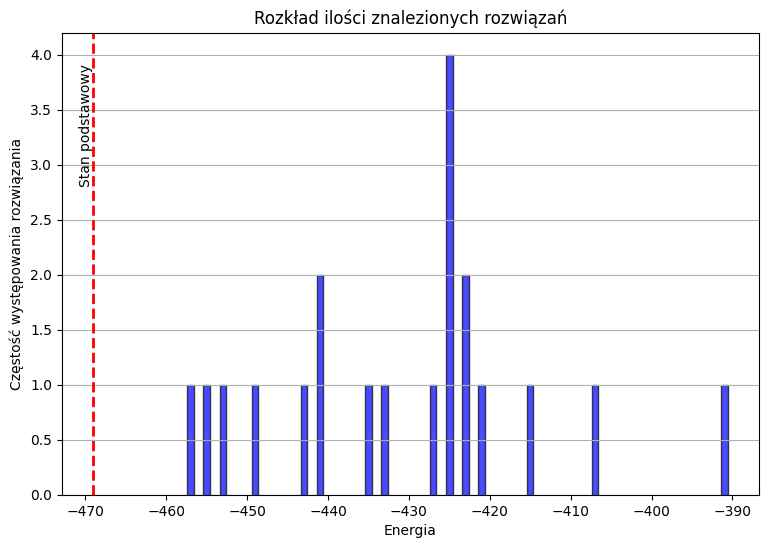

In [5]:
# Test dla małej instancji

import matplotlib.pyplot as plt
from funkcje_pomocnicze import read_instance, small_grid, test_pegasus, Grid10
from tqdm import tqdm

instance = test_pegasus

J, h = read_instance(instance.path)

# Ponieważ jest to probabilistyczny algorytm warto go puścić kilka razy i wybrać najlepszy wynik
energies = []
for _ in tqdm(range(20), desc="wielokrone symulowane wyżarzanie"):
    state, energy = simulated_annealing(J, h, initial_temp=10, final_temp=1e-12, num_steps=1000, num_repeats=10, schedule="exponential")
    energies.append(energy)

print(f"Otrzymana energia: {min(energies)}")
print(f"Najniższa znana energia: {instance.best_energy}")
print(f"Luka energetyczna: {((instance.best_energy - min(energies))/instance.best_energy * 100):.2f}%")

unique_values, counts = np.unique(energies, return_counts=True)


plt.figure(figsize=(9, 6))
plt.bar(unique_values, counts, color='blue', edgecolor='black', alpha=0.7)
#plt.xticks(energies)
plt.axvline(x=test_pegasus.best_energy, color='red', linestyle='--', linewidth=2)
plt.text(test_pegasus.best_energy, plt.ylim()[1]*0.8, 'Stan podstawowy', color='black', rotation=90,
         verticalalignment='center', horizontalalignment='right')

plt.xlabel("Energia")
plt.ylabel("Częstość występowania rozwiązania")
plt.title("Rozkład ilości znalezionych rozwiązań")
plt.grid(axis="y")
plt.show()



## Zaawansowana implementacja

Pokazana tu implementacja jest bardzo podstawowa, przez co nie osiąga zadawalających rezultatów. Istnieje w literaturze wiele, często wyrafinowanych rozszerzeń tego algorytmu. Współcześnie wykorzystuje się adaptacyje schematy (funkcje) chłodzenia, ponowne nagrzewanie i inne techniki. Dobrze zoptymalizowane symulowane wyrzażanie z odpowiednio dobranymi parametrami ciągle pozostaje konkurencyją metodą rozwiązywania problemów QUBO.

100%|██████████| 3/3 [00:16<00:00,  5.49s/it]


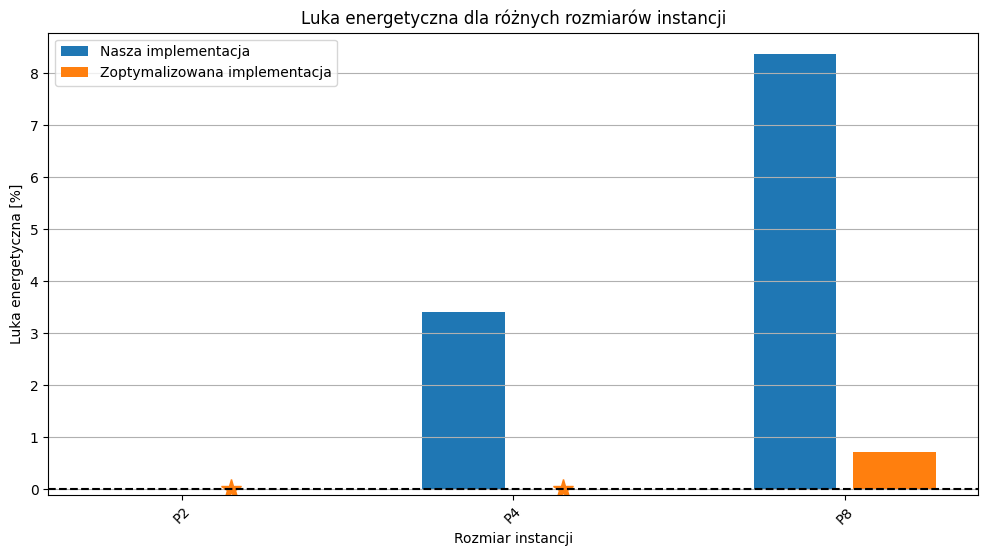

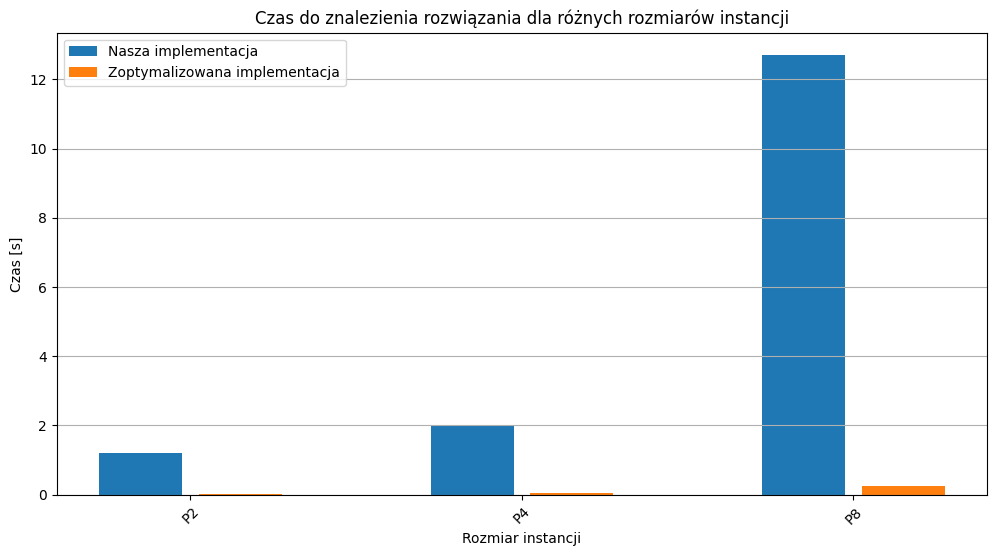

In [4]:
# Przykład użycia zoptymalizowanej implementacji
import time

import matplotlib.pyplot as plt
import numpy as np

from dimod import BinaryQuadraticModel
from dwave.samplers import SimulatedAnnealingSampler
from funkcje_pomocnicze import read_instance, P2, P4, P8, P12, P16
from tqdm import tqdm

sampler= SimulatedAnnealingSampler()
gaps_our = []
times_our = []

gaps_ext = []
times_ext = []


for instance in tqdm([P2, P4, P8]):#, P12, P16], desc="zbieranie_danych"):

    J1, h1 = read_instance(instance.path, convention="minus_half")
    # Nasza implementacja
    energies = []
    begin = time.time()
    for _ in range(10):
        state, energy = simulated_annealing(J1, h1, initial_temp=10, final_temp=1e-12, num_steps=1000, num_repeats=10, schedule="exponential")
        energies.append(energy)
    end = time.time()
    sol = min(energies)
    times_our.append(end-begin)
    gaps_our.append((instance.best_energy - sol)/instance.best_energy * 100)

    J2, h2 = read_instance(instance.path, convention="dwave")

    bqm_instance = BinaryQuadraticModel(h2, J2, vartype="SPIN")
    begin = time.time()
    sampleset = sampler.sample(bqm_instance, num_reads=10)
    end = time.time()
    energy = sampleset.first.energy
    gaps_ext.append((instance.best_energy - energy)/instance.best_energy * 100)
    times_ext.append(end-begin)

fig, ax = plt.subplots(figsize=(12, 6))

instancje = ["P2", "P4", "P8"]

x = np.arange(len(instancje))
width = 0.25
offset = 0.15

bar1 = ax.bar(x - offset, gaps_our, width, label="Nasza implementacja")
bars = ax.bar(x + offset, gaps_ext, width, label="Zoptymalizowana implementacja")


for bar in bars:
    if bar.get_height() == 0:
        center = bar.get_x() + bar.get_width()/2
        ax.plot(center, 0, marker='*', markersize=15, color=bar.get_facecolor())

(y_min, y_max) = ax.get_ylim()
ax.set_ylim((-0.1, y_max))
ax.set_xlabel("Rozmiar instancji")
ax.set_xticks(x)
ax.set_xticklabels(instancje, rotation=45)
ax.set_ylabel("Luka energetyczna [%]")
ax.set_title("Luka energetyczna dla różnych rozmiarów instancji")
ax.axhline(0, color='black', linestyle='--')
#ax.axhline(1, color="red", linestyle="--")
ax.legend()

plt.grid(axis="y")
plt.show()

fig2, ax2 = plt.subplots(figsize=(12, 6))
bar1 = ax2.bar(x - offset, times_our, width, label="Nasza implementacja")
bars = ax2.bar(x + offset, times_ext, width, label="Zoptymalizowana implementacja")

ax2.set_xlabel("Rozmiar instancji")
ax2.set_xticks(x)
ax2.set_xticklabels(instancje, rotation=45)
ax2.set_ylabel("Czas [s]")
ax2.set_title("Czas do znalezienia rozwiązania dla różnych rozmiarów instancji")
ax2.legend()

plt.grid(axis="y")
plt.show()


In [ ]:


# Zoptymalizowana Implementacja dla dużych instancji

# Bibliografia

* Eglese, R.W., Simulated annealing: A tool for operational research. *European Journal of Operational Research*, Volume **46**, Issue **3**, 1990, DOI: [10.1016/0377-2217(90)90001-R](https://doi.org/10.1016/0377-2217(90)90001-R)

* Henderson, D., Jacobson, S.H., Johnson, A.W. (2003). The Theory and Practice of Simulated Annealing. In: Glover, F., Kochenberger, G.A. (eds) Handbook of Metaheuristics. International Series in Operations Research & Management Science, vol 57. Springer, Boston, MA. DOI: [10.1007/0-306-48056-5_10](https://doi.org/10.1007/0-306-48056-5_10)

* Vodeb, J., Eržen, V., Hrga, T., Povh, J. (2024). Accuracy and Performance Evaluation of Quantum, Classical and Hybrid Solvers for the Max-Cut Problem. *ArXiv preprint*, DOI: [10.48550/arXiv.2412.07460](https://doi.org/10.48550/arXiv.2412.07460)
